# Comparison of Similarity: Semsimian vs. Large Language Model Embeddings

## Case 1: HP vs HP

### Setup

In [1]:
!pip install oaklib==0.5.18rc2 polars seaborn seaborn_polars matplotlib
!pip install git+https://github.com/monarch-initiative/ontogpt.git
# Depending on the environment you may also need python3-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 13.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: semsimian
    Found existing installation: semsimian 0.2.1
    Uninstalling semsimian-0.2.1:
      Successfully uninstalled semsimian-0.2.1
  Attempting uninstall: oaklib
    Found existing installation: oaklib 0.5.17
    Uninstalling oaklib-0.5.17:
      Successfully uninstalled oaklib-0.5.17

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/monarch-initiative/ontogpt.git to /tmp/pip-req-build-w0p9ryg2
  Running command git clone --filter=blob:none --quiet https://github.com/monarch-initiative/ontogpt.git /tmp/pip-req-build-w0p9ryg2
  Resolved https://github.com/monarch-initiative/ontogpt.git to commit 4849f4ce7c54f0394c263fdcad832f7a9eabd52b
  Installing build dependencies ... done
  Getting re

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn_polars as snl

from ontogpt.clients import OpenAIClient

In [3]:
simfile = 'hp_vs_hp_semsim.tsv'

### Semsim for HP through Semsimian and OAK

In [6]:
# This is just the descendants of "Abnormality of the voice" - it's only 24 objects
#!runoak -vvv -i semsimian:sqlite:obo:hp similarity -p i .desc//p=i HP:0001608 @ .desc//p=i HP:0001608 -O csv -o {simfile}

# This line will do all PA vs all PA for HP. That's pretty large (>17k objects)
# Plus this is running without a threshold - we really do want to compare everything we can
!runoak -vvv -i semsimian:sqlite:obo:hp similarity -p i .desc//p=i HP:0000118 @ .desc//p=i HP:0000118 -O csv -o {simfile}

INFO:root:Setting other_languages=()
INFO:root:Settings = Settings(impl=None, autosave=False, associations_type=None, preferred_language=None, other_languages=())
INFO:root:Wrapping an existing OAK implementation to fetch sqlite:obo:hp
INFO:root:Locator: obo:hp
INFO:root:Ensuring gunzipped for https://s3.amazonaws.com/bbop-sqlite/hp.db.gz
INFO:root:Locator, post-processed: sqlite:////home/harry/.data/oaklib/hp.db
DEBUG:root:Paths to search: [PurePosixPath('model/schema'), PurePosixPath('schema'), PurePosixPath('linkml'), PurePosixPath('src/linkml'), PurePosixPath('src/model'), PurePosixPath('src/model/schema'), PurePosixPath('src/schema'), PurePosixPath('.')]
DEBUG:root:candidate model/schema not found
DEBUG:root:candidate schema not found
DEBUG:root:candidate linkml not found
DEBUG:root:candidate src/linkml not found
DEBUG:root:candidate src/model not found
DEBUG:root:candidate src/model/schema not found
DEBUG:root:candidate src/schema not found
INFO:root:out=hp_vs_hp_semsim.tsv <clas

In [5]:
!head {simfile}

subject_id	subject_label	subject_source	object_id	object_label	object_source	ancestor_id	ancestor_label	ancestor_source	object_information_content	subject_information_content	ancestor_information_content	jaccard_similarity	cosine_similarity	dice_similarity	phenodigm_score
HP:0025430	High-pitched cry	None	HP:0012822	Bilateral vocal cord paresis	None	HP:0001608	Abnormality of the voice	None	None	None	10.278546254157375	0.23076923076923078	None	None	1.5401208434723088
HP:0025430	High-pitched cry	None	HP:0031801	Vocal cord dysfunction	None	HP:0001608	Abnormality of the voice	None	None	None	10.278546254157375	0.5	None	None	2.2669964991324285
HP:0025430	High-pitched cry	None	HP:0001615	Hoarse cry	None	HP:0001608	Abnormality of the voice	None	None	None	10.278546254157375	0.42857142857142855	None	None	2.0988309250108097
HP:0025430	High-pitched cry	None	HP:0001612	Weak cry	None	HP:0025429	Abnormal cry	None	None	None	12.541580659991169	0.6666666666666666	None	None	2.8915486807811908
HP:0025430	H

In [46]:
simsdf = pl.read_csv(simfile, separator='\t')
simsdf

subject_id,subject_label,subject_source,object_id,object_label,object_source,ancestor_id,ancestor_label,ancestor_source,object_information_content,subject_information_content,ancestor_information_content,jaccard_similarity,cosine_similarity,dice_similarity,phenodigm_score
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0012049""","""Laryngeal dyst…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.272727,"""None""","""None""",1.674288
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0100271""","""Hyponasal spee…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.6,"""None""","""None""",2.48337
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0007024""","""Pseudobulbar p…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.136364,"""None""","""None""",1.1839
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.75,"""None""","""None""",2.776492
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0025429""","""Abnormal cry""","""None""","""HP:0025429""","""Abnormal cry""","""None""","""None""","""None""",12.541581,1.0,"""None""","""None""",3.541409
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0008757""","""Unilateral voc…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.272727,"""None""","""None""",1.674288
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0001605""","""Vocal cord par…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.3,"""None""","""None""",1.756008
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0001611""","""Hypernasal spe…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.6,"""None""","""None""",2.48337
"""HP:0025429""","""Abnormal cry""","""None""","""HP:0012822""","""Bilateral voca…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.25,"""None""","""None""",1.603009


In [8]:
simsdf["jaccard_similarity"].hist(bin_count=2)

break_point,category,jaccard_similarity_count
f64,cat,u32
-1.0,"""(-inf, -1.0]""",0
0.5,"""(-1.0, 0.5]""",414
inf,"""(0.5, inf]""",162


(0.0, 1.0, 0.0, 1.0)

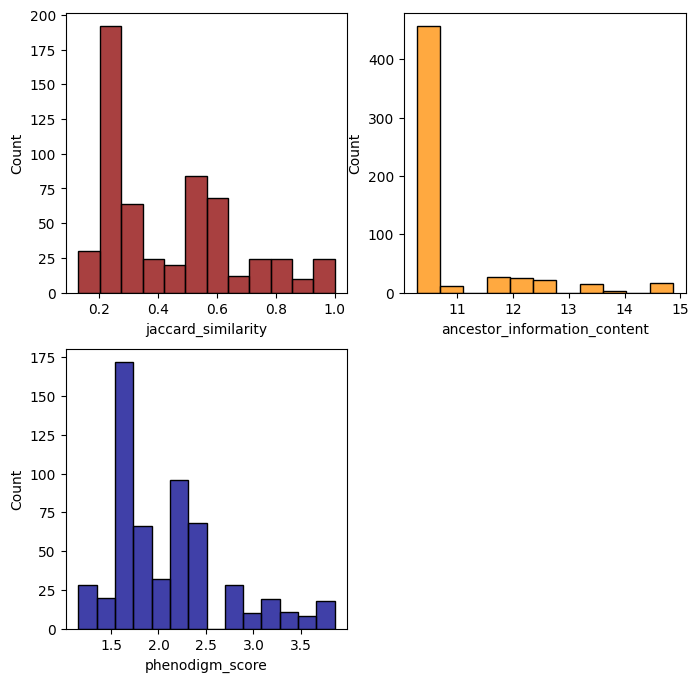

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
snl.histplot(simsdf, x='jaccard_similarity', color="darkred", ax=axs[0, 0])
snl.histplot(simsdf, x='ancestor_information_content', color="darkorange", ax=axs[0, 1])
snl.histplot(simsdf, x='phenodigm_score', color="darkblue", ax=axs[1, 0])
axs[1, 1].axis('off')

### Embeddings for HP through OntoGPT and GPT-3.5

The basic idea here is to get all term labels, get embedding for each, and get cosine sim for each pair.
OntoGPT has the `entity-similarity` command already to do the latter two of these.

In [30]:
embed_cosimfile = 'hp_vs_hp_embed_cosim.tsv'

In [26]:
# Get all the term CURIEs
all_term_ids = set(pl.concat([simsdf["subject_id"], simsdf["object_id"], simsdf["ancestor_id"]]))
all_term_ids

{'HP:0001604',
 'HP:0001605',
 'HP:0001608',
 'HP:0001609',
 'HP:0001611',
 'HP:0001612',
 'HP:0001615',
 'HP:0001618',
 'HP:0001621',
 'HP:0001686',
 'HP:0003470',
 'HP:0005934',
 'HP:0007024',
 'HP:0008757',
 'HP:0009088',
 'HP:0012049',
 'HP:0012820',
 'HP:0012821',
 'HP:0012822',
 'HP:0025429',
 'HP:0025430',
 'HP:0025431',
 'HP:0031801',
 'HP:0100271',
 'HP:0200046'}

In [29]:
# Prep that term list
all_term_str = " ".join(all_term_ids)

In [32]:
# Get cosine sim
!ontogpt entity-similarity -r sqlite:obo:hp {all_term_str} -o {embed_cosimfile} -O yaml

In [33]:
!head {embed_cosimfile}

subject_id	subject_label	object_id	object_label	embedding_cosine_similarity	object_rank_for_subject
HP:0001615	Hoarse cry	HP:0001615	Hoarse cry	1.0000000000000002	0
HP:0001615	Hoarse cry	HP:0001612	Weak cry	0.928651658031122	1
HP:0001615	Hoarse cry	HP:0001608	Abnormality of the voice	0.9232128558034752	2
HP:0001615	Hoarse cry	HP:0001609	Hoarse voice	0.9198167123184476	3
HP:0001615	Hoarse cry	HP:0001686	Loss of voice	0.9166518643996694	4
HP:0001615	Hoarse cry	HP:0025430	High-pitched cry	0.9142521592726314	5
HP:0001615	Hoarse cry	HP:0025429	Abnormal cry	0.9111619386759381	6
HP:0001615	Hoarse cry	HP:0200046	Cat cry	0.8921291710166889	7
HP:0001615	Hoarse cry	HP:0001621	Weak voice	0.8860536218064554	8


In [45]:
embed_cosimsdf = pl.read_csv(embed_cosimfile, separator='\t')
embed_cosimsdf

subject_id,subject_label,object_id,object_label,embedding_cosine_similarity,object_rank_for_subject
str,str,str,str,f64,i64
"""HP:0001615""","""Hoarse cry""","""HP:0001615""","""Hoarse cry""",1.0,0
"""HP:0001615""","""Hoarse cry""","""HP:0001612""","""Weak cry""",0.928652,1
"""HP:0001615""","""Hoarse cry""","""HP:0001608""","""Abnormality of…",0.923213,2
"""HP:0001615""","""Hoarse cry""","""HP:0001609""","""Hoarse voice""",0.919817,3
"""HP:0001615""","""Hoarse cry""","""HP:0001686""","""Loss of voice""",0.916652,4
"""HP:0001615""","""Hoarse cry""","""HP:0025430""","""High-pitched c…",0.914252,5
"""HP:0001615""","""Hoarse cry""","""HP:0025429""","""Abnormal cry""",0.911162,6
"""HP:0001615""","""Hoarse cry""","""HP:0200046""","""Cat cry""",0.892129,7
"""HP:0001615""","""Hoarse cry""","""HP:0001621""","""Weak voice""",0.886054,8


### Combined plot

In [47]:
# Join the dfs
simsdf = simsdf.with_columns(simsdf.select(pl.col("subject_id") + "+" + pl.col("object_id")))
embed_cosimsdf = embed_cosimsdf.with_columns(embed_cosimsdf.select(pl.col("subject_id") + "+" + pl.col("object_id")))
simsdf = simsdf.join(embed_cosimsdf, on="subject_id")

In [48]:
simsdf

subject_id,subject_label,subject_source,object_id,object_label,object_source,ancestor_id,ancestor_label,ancestor_source,object_information_content,subject_information_content,ancestor_information_content,jaccard_similarity,cosine_similarity,dice_similarity,phenodigm_score,subject_label_right,object_id_right,object_label_right,embedding_cosine_similarity,object_rank_for_subject
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,str,str,str,f64,i64
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001615""","""Hoarse cry""","""None""","""HP:0001615""","""Hoarse cry""","""None""","""None""","""None""",14.863509,1.0,"""None""","""None""",3.855322,"""Hoarse cry""","""HP:0001615""","""Hoarse cry""",1.0,0
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001612""","""Weak cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.428571,"""None""","""None""",2.098831,"""Hoarse cry""","""HP:0001612""","""Weak cry""",0.928652,1
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.6,"""None""","""None""",2.48337,"""Hoarse cry""","""HP:0001608""","""Abnormality of…",0.923213,2
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001609""","""Hoarse voice""","""None""","""HP:0001609""","""Hoarse voice""","""None""","""None""","""None""",13.863509,0.8,"""None""","""None""",3.330286,"""Hoarse cry""","""HP:0001609""","""Hoarse voice""",0.919817,3
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001686""","""Loss of voice""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996,"""Hoarse cry""","""HP:0001686""","""Loss of voice""",0.916652,4
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0025430""","""High-pitched c…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.428571,"""None""","""None""",2.098831,"""Hoarse cry""","""HP:0025430""","""High-pitched c…",0.914252,5
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0025429""","""Abnormal cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996,"""Hoarse cry""","""HP:0025429""","""Abnormal cry""",0.911162,6
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0200046""","""Cat cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.428571,"""None""","""None""",2.098831,"""Hoarse cry""","""HP:0200046""","""Cat cry""",0.892129,7
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001621""","""Weak voice""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996,"""Hoarse cry""","""HP:0001621""","""Weak voice""",0.886054,8


(0.0, 1.0, 0.0, 1.0)

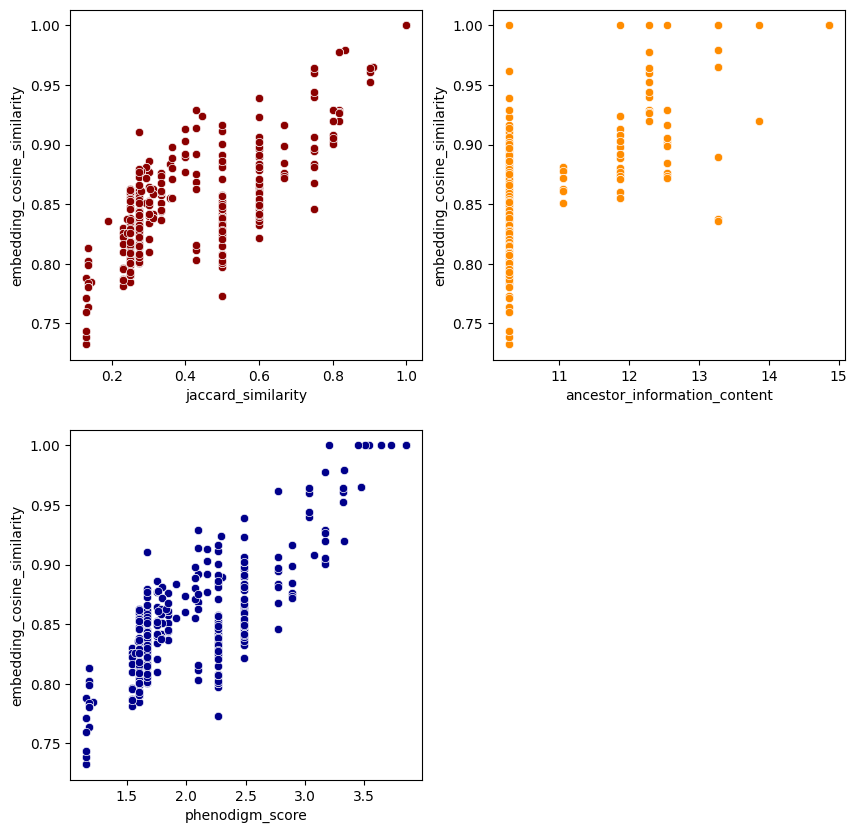

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
snl.scatterplot(simsdf, x='jaccard_similarity', y='embedding_cosine_similarity', color="darkred", ax=axs[0, 0])
snl.scatterplot(simsdf, x='ancestor_information_content', y='embedding_cosine_similarity', color="darkorange", ax=axs[0, 1])
snl.scatterplot(simsdf, x='phenodigm_score', y='embedding_cosine_similarity', color="darkblue", ax=axs[1, 0])
axs[1, 1].axis('off')